In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from pinn import gradient, PINN, Trainer

## Burgers' Equation

$$\frac{du}{dt} + u\frac{du}{dx} - \frac{0.01}{\pi}\frac{d^2u}{dx^2}, \quad x \in [-1, 1], \quad t \in [0, 1]$$

Initial conditon:

$$u(x, 0) = -\sin(\pi x), \quad x \in [-1, 1]$$

Boundary conditions:

$$u(-1, t) = u(1, t) = 0, \quad t \in [0, 1]$$

In [20]:
def residual_loss(model, inputs):
    x, t = inputs
    x.requires_grad = True
    t.requires_grad = True
    u = model([x, t])
    u_x = gradient(u, x)        # du/dx
    u_t = gradient(u, t)        # du/dt
    u_xx = gradient(u_x, x)     # d2u/dxdx
    residual = u_t + u * u_x - (0.01/np.pi) * u_xx
    return torch.mean(residual**2)

def ic_loss(model, inputs):
    x, t = inputs
    x.requires_grad = True
    t0 = torch.full_like(x, 0)          # t = 0
    u = model([x, t0])
    return torch.mean((u - ic(x))**2)

def bc_left_loss(model, inputs):
    x, t = inputs
    t.requires_grad = True
    x_left = torch.full_like(t, -1.0)   # x = -1
    u = model([x_left, t])
    return torch.mean((u - bc_left(t))**2)

def bc_right_loss(model, inputs):
    x, t = inputs
    t.requires_grad = True
    x_right = torch.full_like(t, 1.0)   # x = 1
    u = model([x_right, t])
    return torch.mean((u - bc_right(t))**2)

def ic(x):
    return -torch.sin(np.pi * x)    # u(x, 0) = -sin(pi*x)

def bc_left(t):
    return torch.full_like(t, 0.0)  # u(-1, t) = 0

def bc_right(t):
    return torch.full_like(t, 0.0)  # u(1, t) = 0

In [22]:
## Hyperparameters
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 1000
learning_rate = 1e-3
layers = [2, 50, 50, 50, 1]

## Training Data
x_min, x_max, x_size = -1, 1, 201
t_min, t_max, t_size = 0, 1, 101

x_np = np.linspace(x_min, x_max, x_size)
t_np = np.linspace(t_min, t_max, t_size)

x_train_np, t_train_np = np.meshgrid(x_np, t_np, indexing="xy")
x_train_np, t_train_np = x_train_np.flatten(), t_train_np.flatten()

## numpy array to torch tensor
x = torch.from_numpy(x_np).float().view(-1, 1).to(device)
t = torch.from_numpy(t_np).float().view(-1, 1).to(device)
x_train = torch.from_numpy(x_train_np).float().view(-1, 1).to(device)
t_train = torch.from_numpy(t_train_np).float().view(-1, 1).to(device)

## Modeling and Training
model = PINN(layers_dim=layers, activation="tanh").to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

loss_functions = {}
loss_functions["residual"] = residual_loss
loss_functions["ic"] = ic_loss
loss_functions["bc_left"] = bc_left_loss
loss_functions["bc_right"] = bc_right_loss

targets = {}
burgers = Trainer(model, optimizer, loss_functions, targets)
history = burgers.fit([x_train, t_train], n_epochs, scheduler=scheduler)

Epoch[1000/1000] (lr: 6.30e-04) TOTAL: 8.14e-02, RESIDUAL: 3.47e-02, IC: 4.64e-02, BC_LEFT: 2.22e-04, BC_RIGHT: 9.03e-05: 100%|#####################################| 1000/1000 [01:43<00:00,  9.71it/s]


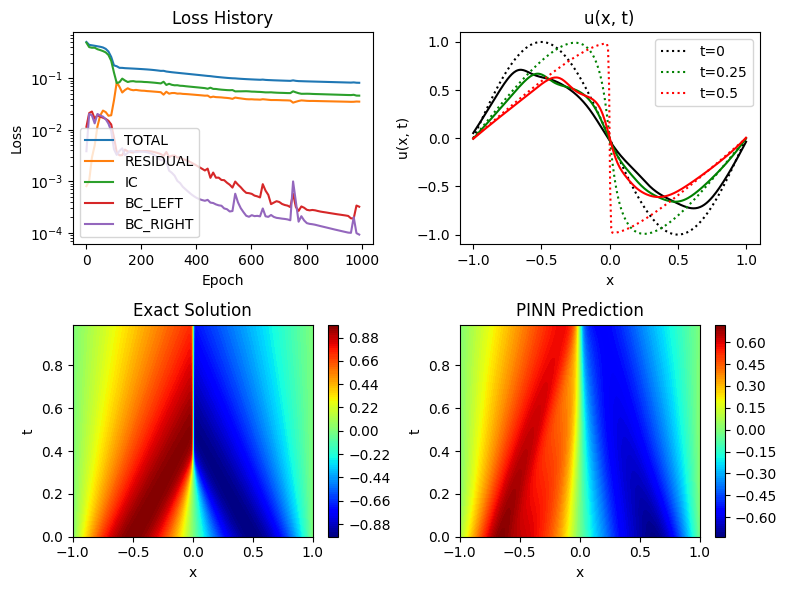

In [ ]:
## Result
import scipy

data = scipy.io.loadmat("burgers_shock.mat")
x_np = data["x"].flatten()          # (256, )
t_np = data["t"].flatten()          # (100, )
u_sol = np.real(data["usol"]).T     # (100, 256)
X, T = np.meshgrid(x_np, t_np)      # (100, 256), (100, 256)

x = torch.tensor(X.flatten()).float().view(-1, 1).to(device)
t = torch.tensor(T.flatten()).float().view(-1, 1).to(device)
u_pred = burgers.predict([x, t]).reshape(X.shape)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))
for name in history:
    epochs = range(1, n_epochs + 1)
    ax1.semilogy(epochs[::10], history[name][::10], label=name.upper())
ax1.legend(loc="lower left"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")

ax2.plot(x_np, u_sol[0, :], 'k:', label="t=0")
ax2.plot(x_np, u_pred[0, :], 'k')
ax2.plot(x_np, u_sol[25, :], 'g:', label="t=0.25")
ax2.plot(x_np, u_pred[25, :], 'g')
ax2.plot(x_np, u_sol[50, :], 'r:', label="t=0.5")
ax2.plot(x_np, u_pred[50, :], 'r')
ax2.legend(loc="upper right"); ax2.set_xlabel("x"); ax2.set_ylabel("u(x, t)")

cp1 = ax3.contourf(X, T, u_sol, levels=100, cmap="jet")
cp2 = ax4.contourf(X, T, u_pred, levels=100, cmap="jet")
fig.colorbar(cp1)
fig.colorbar(cp2)

ax1.set_title("Loss History")
ax2.set_title("u(x, t)")
ax3.set_title("Exact Solution")
ax4.set_title("PINN Prediction")

for ax in (ax3, ax4):
    ax.set_xlabel("x")
    ax.set_ylabel("t")

fig.tight_layout()
plt.show()

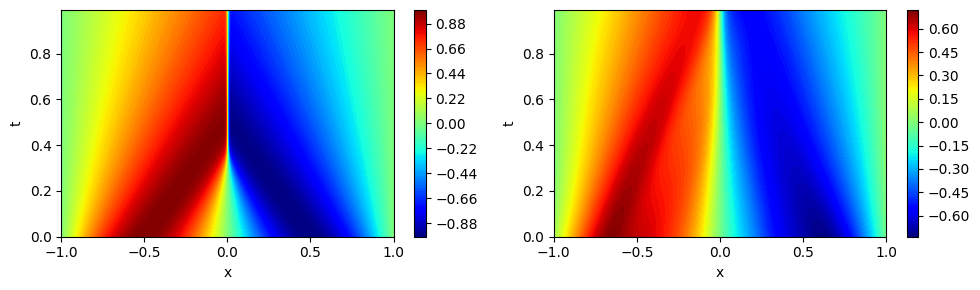

In [77]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
cp1 = ax1.contourf(X, T, u_sol, levels=100, cmap="jet")
cp2 = ax2.contourf(X, T, u_pred, levels=100, cmap="jet")
fig.colorbar(cp1)
fig.colorbar(cp2)

for ax in (ax1, ax2):
    ax.set_xlabel("x")
    ax.set_ylabel("t")
fig.tight_layout()
plt.show()

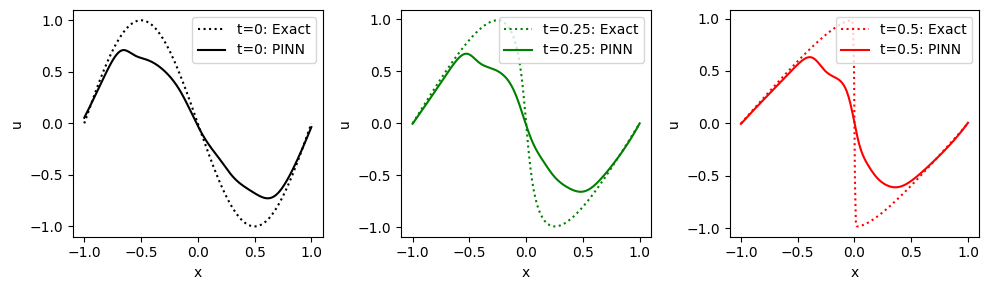

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 3))
ax1.plot(x_np, u_sol[0, :], 'k:', label="t=0: Exact")
ax1.plot(x_np, u_pred[0, :], 'k', label="t=0: PINN")

ax2.plot(x_np, u_sol[25, :], 'g:', label="t=0.25: Exact")
ax2.plot(x_np, u_pred[25, :], 'g', label="t=0.25: PINN")

ax3.plot(x_np, u_sol[50, :], 'r:', label="t=0.5: Exact")
ax3.plot(x_np, u_pred[50, :], 'r', label="t=0.5: PINN")

for ax in (ax1, ax2, ax3):
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend(loc="upper right")
fig.tight_layout()
plt.show()